In [32]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [33]:
!pip install keras

Defaulting to user installation because normal site-packages is not writeable


In [34]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models


#  Завантаження та підготовка даних
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# VGG16 очікує 3-канальні зображення 224x224 - ноут мій не потягнув, то беру меньше -96х96
x_train = np.stack([x_train]*3, axis=-1)   # робимо 3 канали
x_test = np.stack([x_test]*3, axis=-1)

#x_train = tf.image.resize(x_train, (96,96)).numpy()
#x_test = tf.image.resize(x_test, (96,96)).numpy()

#x_train = x_train.astype("float32") / 255.0
#x_test = x_test.astype("float32") / 255.0

#y_train_cat = to_categorical(y_train, 10)
#y_test_cat = to_categorical(y_test, 10)
#видавало MemoryError: Unable to allocate 6.18 GiB for an array with shape (60000, 96, 96, 3) and data type float32, то довелося
# Еренувальний та тестовий датасети:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# 4.Препроцесинг:
def preprocess(img, label):
    img = tf.image.resize(img, (96,96))   # 96x96
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.one_hot(label, 10)         # one-hot прямо тут
    return img, label

# Застосовуємо препроцесинг:
batch_size = 64
train_ds = (train_ds
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(10000)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

test_ds = (test_ds
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))

for images, labels in train_ds.take(1):
    print("Batch images shape:", images.shape)
    print("Batch labels shape:", labels.shape)


Batch images shape: (64, 96, 96, 3)
Batch labels shape: (64, 10)


In [35]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(96,96,3))
conv_base.trainable = False

model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax"),
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [36]:
history = model.fit(train_ds, epochs=5, validation_data=test_ds) #5 епох   
#повільно навчається  

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1319s 1s/step - accuracy: 0.8097 - loss: 0.5599 - val_accuracy: 0.8747 - val_loss: 0.3560
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1313s 1s/step - accuracy: 0.8730 - loss: 0.3597 - val_accuracy: 0.8843 - val_loss: 0.3169
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1351s 1s/step - accuracy: 0.8876 - loss: 0.3182 - val_accuracy: 0.8893 - val_loss: 0.2963
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1329s 1s/step - accuracy: 0.8961 - loss: 0.2921 - val_accuracy: 0.8969 - val_loss: 0.2823
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1309s 1s/step - accuracy: 0.9021 - loss: 0.2751 - val_accuracy: 0.8975 - val_loss: 0.2775


In [52]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


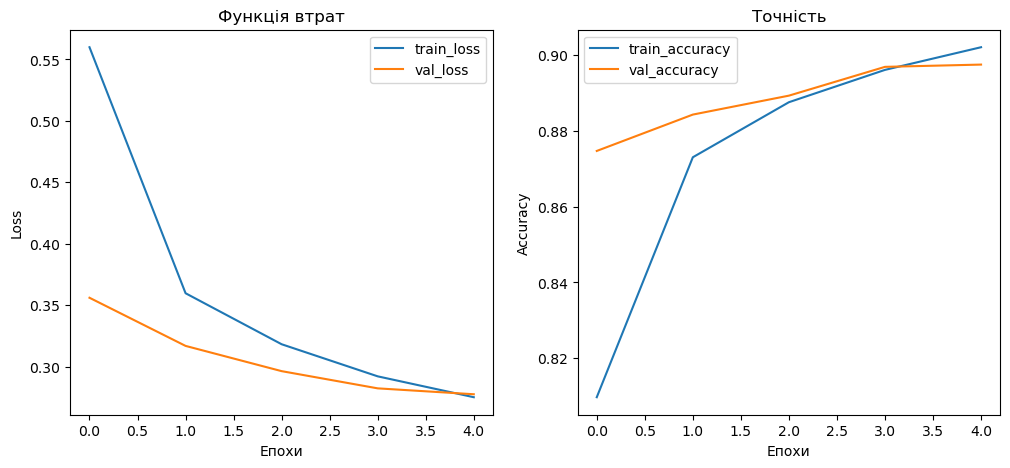

In [38]:
# графіки залежності зміни точності і втрат від кроку
# точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# --- Графік функції втрат ---
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Функція втрат")
plt.xlabel("Епохи")
plt.ylabel("Loss")
plt.legend()

# --- Графік точності ---
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("Точність")
plt.xlabel("Епохи")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

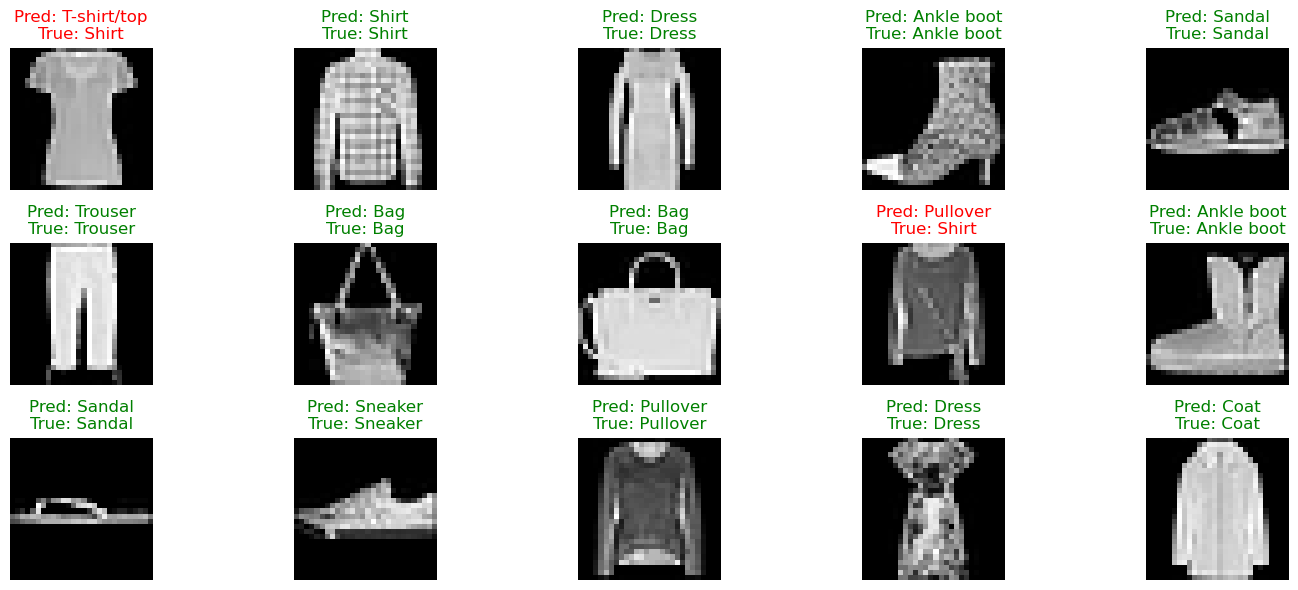

In [50]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class_names = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

plt.figure(figsize=(15, 6))

for i in range(15):
    idx = random.randint(0, x_test.shape[0] - 1)
    img_display = x_test[idx]  # оригінальне зображення

    # Ресайз до 96x96
    img_resized = tf.image.resize(img_display, (96,96))

    # Дублюємо канали тільки якщо менше 3
    if img_resized.shape[-1] == 1 or len(img_resized.shape) == 2:
        img_resized = img_resized[..., np.newaxis] if len(img_resized.shape)==2 else img_resized
        img_rgb = tf.repeat(img_resized, repeats=3, axis=-1)
    else:
        img_rgb = img_resized  # вже 3 канали

    # Нормалізація
    img_rgb = tf.cast(img_rgb, tf.float32) / 255.0
    img_input = tf.expand_dims(img_rgb, axis=0)  # 1x96x96x3

    # Передбачення
    pred_all = model.predict(img_input, verbose=0)
    pred_class = np.argmax(pred_all, axis=1)[0]

    true_class = y_test[idx]

    # Візуалізація
    plt.subplot(3, 5, i+1)
    plt.imshow(img_display.squeeze(), cmap="gray")
    color = "green" if pred_class == true_class else "red"
    plt.title(f"Pred: {class_names[pred_class]}\nTrue: {class_names[true_class]}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()
